  Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   
3               6.0            MANUAL  rear wheel drive              2.0   
4               6.0            MANUAL  rear wheel drive              2.0   

                         Market Category Vehicle Size Vehicle Style  \
0  Factory Tuner,Luxury,High-Performance      Compact         C

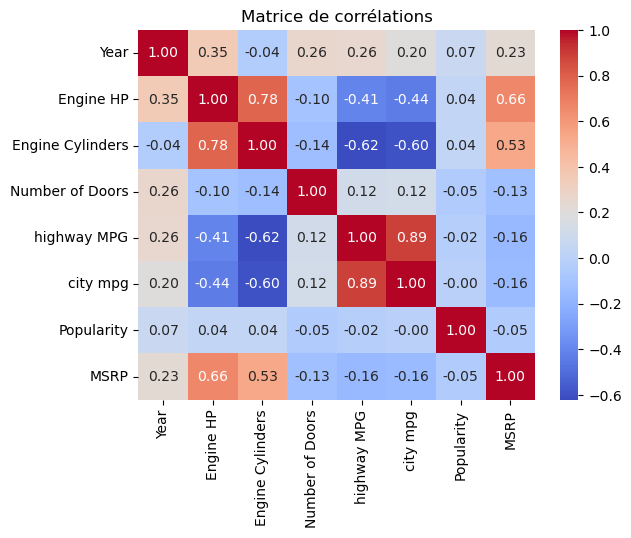

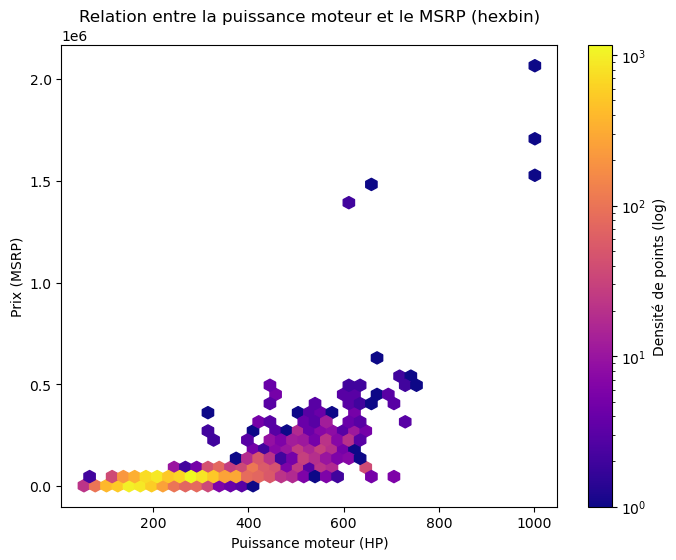

C:\Users\alexi\AppData\Local\Temp\ipykernel_54120\4246287410.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')


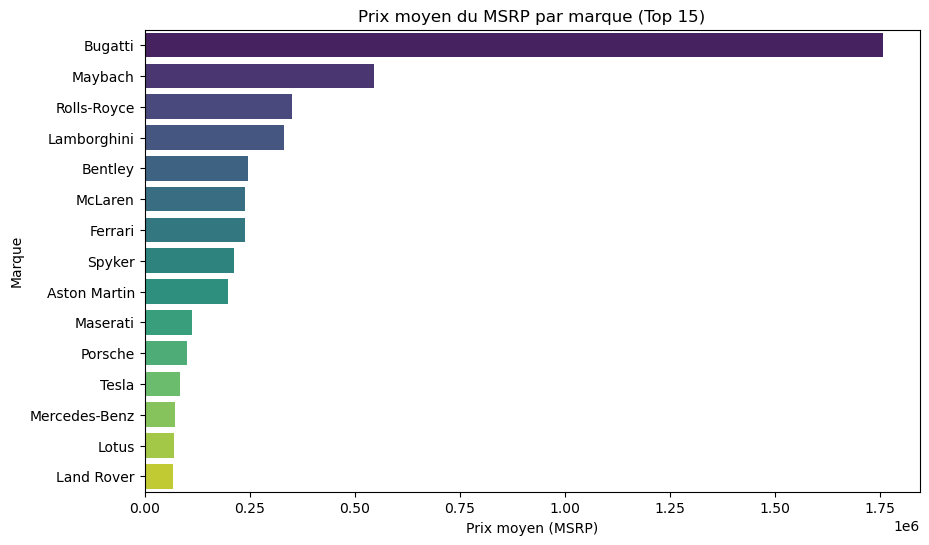

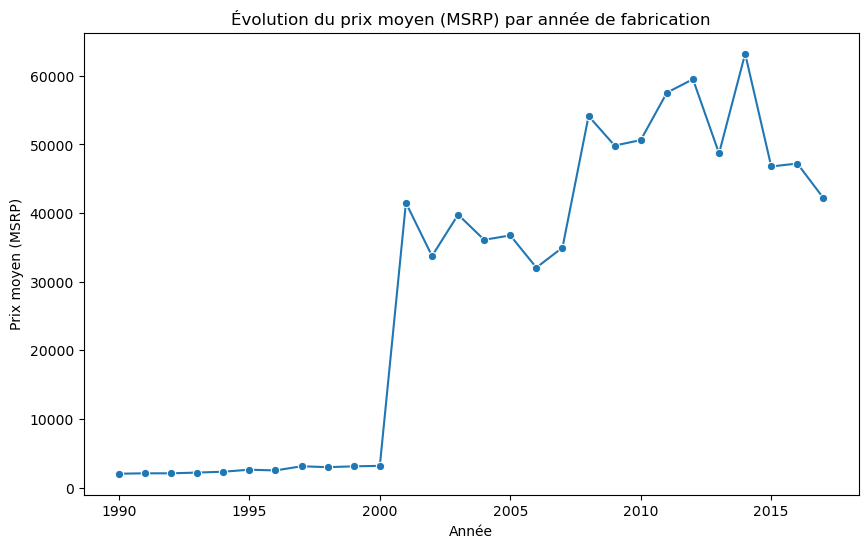

In [1]:
# 1. Descriptive analysis of data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')

print(df.head())
print(df.info())
print(df.describe(include='all'))

# Nombre de valeurs manquantes par colonne
print(df.isnull().sum())

# Statistiques sur la variable cible MSRP
print('Statistiques sur la colonne MSRP :')
print(df['MSRP'].describe())

# Variables catégorielles principales
categoricals = ['Make', 'Model', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size', 'Vehicle Style']

for col in categoricals:
    print(f"--- {col} ---")
    print(f"Nombre de valeurs uniques : {df[col].nunique()}")
    print("Fréquence des 10 valeurs les plus fréquentes :")
    print(df[col].value_counts().head(10))
    print("\n")

# Matrice de corrélation des variables numériques
corr = df.select_dtypes('number').corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice de corrélations')
plt.show()

# 1. Graphique en hexbin
plt.figure(figsize=(8,6))
plt.hexbin(df['Engine HP'], df['MSRP'], gridsize=40, cmap='plasma', bins='log')
plt.colorbar(label='Densité de points (log)')
plt.title("Relation entre la puissance moteur et le MSRP (hexbin)")
plt.xlabel("Puissance moteur (HP)")
plt.ylabel("Prix (MSRP)")
plt.show()

# 2. Prix moyen par marque (top 15 marques)
plt.figure(figsize=(10,6))
top_brands = df.groupby('Make')['MSRP'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')
plt.title("Prix moyen du MSRP par marque (Top 15)")
plt.xlabel("Prix moyen (MSRP)")
plt.ylabel("Marque")
plt.show()

# 3. Evolution du MSRP moyen par année
plt.figure(figsize=(10,6))
yearly_price = df.groupby('Year')['MSRP'].mean().reset_index()
sns.lineplot(data=yearly_price, x='Year', y='MSRP', marker='o')
plt.title("Évolution du prix moyen (MSRP) par année de fabrication")
plt.xlabel("Année")
plt.ylabel("Prix moyen (MSRP)")
plt.show()

On remarque bien que la colonne Market Category est à supprimer car elle contient 3742 valeurs manquantes. La colonne Engine HP a elle 69 valeurs manquantes mais nous allons quand même la garder car on remarque grâce à la matrice de corrélation qu'elle a un impact assez important pour le MSRP.  Egalement, on remarque qu'une matrice de corrélation entre chaque colonne n'est pas forcément optimale, il faudrait plus un tableau pour montrer la corrélation entre le MSRP et les autres colonnes.

In [4]:
# On enlève la colonne 'Market Category'
df_clean = df.drop(columns=['Market Category'])

# encodage temporaire des colonnes catégorielles pour calculer les corrélations
df_encoded = df_clean.copy()
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = pd.factorize(df_encoded[col])[0]

# calcul de la corrélation de chaque colonne avec le MSRP
corr_full = df_encoded.corr()['MSRP'].sort_values(ascending=False)
corr_table_full = corr_full.to_frame().rename(columns={'MSRP': 'Correlation_with_MSRP'})

print(corr_table_full)

                   Correlation_with_MSRP
MSRP                            1.000000
Engine HP                       0.662008
Engine Cylinders                0.531312
Year                            0.227590
Transmission Type               0.193699
Vehicle Size                    0.120323
Make                            0.047817
Model                          -0.027905
Driven_Wheels                  -0.030447
Popularity                     -0.048476
Engine Fuel Type               -0.110847
Number of Doors                -0.126635
city mpg                       -0.157676
highway MPG                    -0.160043
Vehicle Style                  -0.207915


On voit donc ici que les colonnes Engine Hp et Engine cylinders sont les plus importantes,  donc ce qui tourne autour du moteur et des performances finalement.

In [7]:
# 2. Implementation of the necessary pre-processing.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Imputation des valeurs manquantes numériques par la moyenne
imp_num = SimpleImputer(strategy='mean')
num_cols = df_clean.select_dtypes(include=['number']).columns
df_clean[num_cols] = imp_num.fit_transform(df_clean[num_cols])

# Imputation des variables catégorielles par la valeur la plus fréquente
imp_cat = SimpleImputer(strategy='most_frequent')
cat_cols = df_clean.select_dtypes(include=['object']).columns
df_clean[cat_cols] = imp_cat.fit_transform(df_clean[cat_cols])

# Encodage label des variables catégorielles
le = LabelEncoder()
for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

# Séparation X/y
X = df_clean.drop(columns=['MSRP'])
y = df_clean['MSRP']

# Split train/test (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# le pré-processing est fait
print(f"Taille X_train : {X_train.shape}, Taille X_test : {X_test.shape}")



Taille X_train : (9531, 14), Taille X_test : (2383, 14)


In [9]:
print("Valeurs manquantes dans X_train :", X_train.isnull().sum().sum())
print("Valeurs manquantes dans X_test :", X_test.isnull().sum().sum())
print("Valeurs manquantes dans y_train :", y_train.isnull().sum())
print("Valeurs manquantes dans y_test :", y_test.isnull().sum())


Valeurs manquantes dans X_train : 0
Valeurs manquantes dans X_test : 0
Valeurs manquantes dans y_train : 0
Valeurs manquantes dans y_test : 0


à la suite du pré-processing on vérifie bien si il n'y a plus aucune valeurs manquantes. On a bien  0 pour chacune donc c'est tout bon.

In [12]:
# 3. Formalisation of the problem.

# Type de problème
print("Problème de régression supervisée : prédire le prix MSRP d’une voiture à partir de ses caractéristiques techniques.")

# Variables cible et explicatives
target = 'MSRP'
features = [col for col in df_clean.columns if col != target]
print(f"Variable cible : {target}")
print(f"Variables explicatives : {features}")

# Objectif du modèle
print("Objectif : Construire un modèle qui estime le MSRP à partir des caractéristiques des véhicules.")

# Métriques recommandées
print("Métriques pour évaluer les performances du modèle : MAE, RMSE, R^2")



Problème de régression supervisée : prédire le prix MSRP d’une voiture à partir de ses caractéristiques techniques.
Variable cible : MSRP
Variables explicatives : ['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Driven_Wheels', 'Number of Doors', 'Vehicle Size', 'Vehicle Style', 'highway MPG', 'city mpg', 'Popularity']
Objectif : Construire un modèle qui estime le MSRP à partir des caractéristiques des véhicules.
Métriques pour évaluer les performances du modèle : MAE, RMSE, R^2


In [14]:
# 4. Selection of a baseline model and implementation of the model.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Création et entraînement du modèle baseline : ici une régression linéaire simple
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)  

# Prédictions sur le set de test
y_pred = baseline_model.predict(X_test)

# Calcul des métriques d'évaluation
# Ces indicateurs permettent de juger la performance du modèle (plus ils sont faibles, meilleure la prédiction)
mae = mean_absolute_error(y_test, y_pred)           
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
r2 = r2_score(y_test, y_pred)                       

# résultats du modèle
print("Baseline Linear Regression ")
print(f"MAE (Mean Absolute Error) : {mae:.2f}")
print(f"RMSE (Root Mean Squared Error) : {rmse:.2f}")
print(f"R^2 (coefficient de détermination) : {r2:.3f}")


Baseline Linear Regression 
MAE (Mean Absolute Error) : 19945.52
RMSE (Root Mean Squared Error) : 31667.29
R^2 (coefficient de détermination) : 0.579


Première Interprétation des résultats : 

- En moyenne, le modèle se trompe d'environ 20 000 € sur le prix réel des voitures de l'ensemble de test.
- L'écart-type des erreurs de prédiction est élevé, ce qui confirme que certaines prédictions comportent des erreurs importantes.
- Le modèle explique environ 58 % de la variance du prix. On comprend donc donc que 42% de la variance reste inexpliquée.

Améliorations possibles : 

- La différence de prix élévé entre les véhicules biaisent sûrement la regression linéaire. Pour stabiliser cela onn peut enlever ou transformer les outliers.
- Travailler en log(MSRP) pour réduire l’impact des prix extrêmes et rendre la relation plus linéaire.
- On peut également essayer d'autres modèles comme un modèle d’arbres de décision ou de forêt aléatoire.

L’étape suivante logique serait donc d’améliorer le prétraitement (traitement outliers et encodage) et de passer à des modèles non linéaire mais plus complexe.